In [1]:
%load_ext autoreload
%autoreload 2

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
from scrinet.workflow.pipe_utils import load_model
from scrinet.sample import sample_helpers
from scrinet.analysis import timeseries_batch as ts

import matplotlib.pyplot as plt
import numpy as np
import lal

import time as time_1
import tensorflow as tf
import tensorflow_probability as tfp

import arviz as az
import seaborn as sns

tfb = tfp.bijectors
tfd = tfp.distributions

<IPython.core.display.Javascript object>

In [3]:
def setup_surrogate(user="rg"):
    if user == "sk":
        #         rootdir = "/Users/spx8sk/work/data/scrinet/3D_NP"
        rootdir = "/Users/spx8sk/work/data/scrinet/ann-sur-final-model"
    elif user == "rg":
        rootdir = "/Users/Rhys/Documents/PhD/PE/NN_for_PE/ann-sur-final-model"

    amp_basis = os.path.join(rootdir, "amp_eim_basis.npy")
    amp_model_dir = os.path.join(rootdir, "results_4_320_relu_Adam")

    phase_basis = os.path.join(rootdir, "phase_eim_basis.npy")
    phase_model_dir = os.path.join(rootdir, "results_4_320_softplus_Adamax")

    amp_model, amp_basis = load_model(
        basis_file=amp_basis,
        nn_weights_file=os.path.join(amp_model_dir, "model.h5"),
        X_scalers_file=os.path.join(amp_model_dir, "X_scalers.npy"),
        Y_scalers_file="",
    )

    phase_model, phase_basis = load_model(
        basis_file=phase_basis,
        nn_weights_file=os.path.join(phase_model_dir, "model.h5"),
        X_scalers_file=os.path.join(phase_model_dir, "X_scalers.npy"),
        Y_scalers_file=os.path.join(phase_model_dir, "y_scalers.npy"),
    )

    amp_basis = tf.convert_to_tensor(amp_basis, dtype=tf.float32)
    phase_basis = tf.convert_to_tensor(phase_basis, dtype=tf.float32)

    return amp_model, amp_basis, phase_model, phase_basis

<IPython.core.display.Javascript object>

In [4]:
amp_model, amp_basis, phase_model, phase_basis = setup_surrogate(user="rg")

<IPython.core.display.Javascript object>

In [5]:
x = tf.constant([[4, 0, 0], [6, 0, 0], [6, 1, 1]], dtype=np.float32)
theta = tf.constant([[np.pi / 3], [np.pi / 2], [np.pi / 3]])
phi = tf.constant([[np.pi], [np.pi / 2], [np.pi / 8]])
mtot = tf.constant([[70.0], [70.0], [80.0]])
dist = tf.constant([[2.3], [2.3], [2.3]])
phase_shift = tf.constant([[1.0], [2.0], [-1.23]])


f_lower = 20.0


seglen = 4.0
# seglen = 8.

# this is actually dt...
sample_rate = 2048.0 * 2


ra = tf.cast(tf.ones_like(dist), tf.float64)
dec = tf.cast(tf.ones_like(dist), tf.float64)
psi = tf.cast(tf.ones_like(dist), tf.float64)
time = tf.cast(
    tf.constant(
        [
            [
                3.0,
            ],
            [2.0],
            [2.5],
        ]
    ),
    tf.float64,
)



<IPython.core.display.Javascript object>

In [6]:
wvf_params = sample_helpers.WaveformParams(
    distance=dist,
    m_tot=mtot,
    mass_ratio=tf.reshape(x[:, 0], (-1, 1)),
    chi_1=tf.reshape(x[:, 1], (-1, 1)),
    chi_2=tf.reshape(x[:, 2], (-1, 1)),
    theta=theta,
    phi=phi,
    phase_shift=phase_shift,
)

det_params = sample_helpers.DetectorParams(ra=ra, dec=dec, psi=psi, time=time)

<IPython.core.display.Javascript object>

In [7]:
# # f_lower and sample-rate should always be constant and so can just be scalars (0-D Tensor)
(
    surr_times_sec,
    hplus,
    hcross,
    unrolled_peak_time,
) = sample_helpers.generate_surrogate_hp_hc(
    waveform_params=wvf_params,
    n_batch=x.shape[0],
    f_lower=f_lower,
    seglen=seglen,
    sample_rate=sample_rate,
    amp_model=amp_model,
    amp_basis=amp_basis,
    phase_model=phase_model,
    phase_basis=phase_basis,
)

tf.Tensor(32022, shape=(), dtype=int32)


<IPython.core.display.Javascript object>

In [8]:
t = 2

<IPython.core.display.Javascript object>

In [9]:
f_lower = 20.0

<IPython.core.display.Javascript object>

In [30]:
H1_det_wf = sample_helpers.tf_generate_surrogate_at_detector(
    waveform_params=wvf_params,
    detector_params=det_params,
    n_batch=x.shape[0],
    f_lower=f_lower,
    seglen=seglen,
    sample_rate=sample_rate,
    amp_model=amp_model,
    amp_basis=amp_basis,
    phase_model=phase_model,
    phase_basis=phase_basis,
    detector="H1",
)

tf.Tensor(32022, shape=(), dtype=int32)


<IPython.core.display.Javascript object>

In [31]:
L1_det_wf = sample_helpers.tf_generate_surrogate_at_detector(
    waveform_params=wvf_params,
    detector_params=det_params,
    n_batch=x.shape[0],
    f_lower=f_lower,
    seglen=seglen,
    sample_rate=sample_rate,
    amp_model=amp_model,
    amp_basis=amp_basis,
    phase_model=phase_model,
    phase_basis=phase_basis,
    detector="L1",
)

tf.Tensor(32022, shape=(), dtype=int32)


<IPython.core.display.Javascript object>

In [32]:
1 / sample_rate

0.000244140625

<IPython.core.display.Javascript object>

In [33]:
delta_t = surr_times_sec[1] - surr_times_sec[0]

<IPython.core.display.Javascript object>

In [34]:
H1_det_wf = ts.TimeSeries(H1_det_wf, delta_t=delta_t)
L1_det_wf = ts.TimeSeries(L1_det_wf, delta_t=delta_t)

<IPython.core.display.Javascript object>

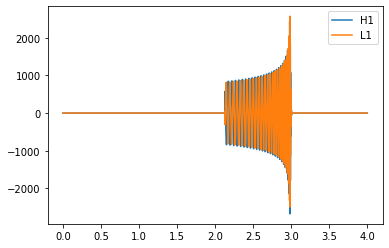

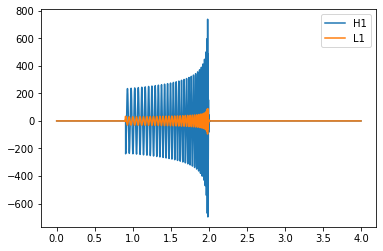

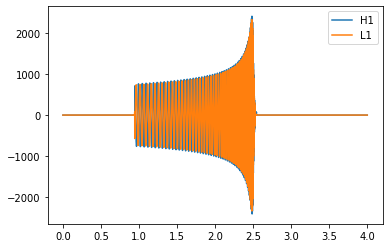

<IPython.core.display.Javascript object>

In [29]:
for i in range(H1_det_wf.data.shape[0]):
    plt.figure()
    plt.plot(H1_det_wf.sample_times[i], H1_det_wf.data[i], label="H1")
    plt.plot(L1_det_wf.sample_times[i], L1_det_wf.data[i], label="L1")
    plt.legend()
#     plt.xlim(2.5, 3.0)


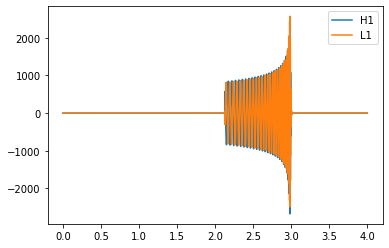

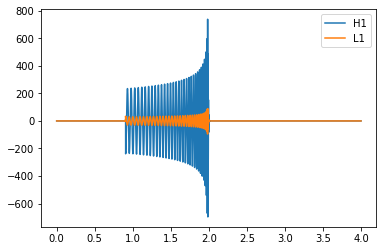

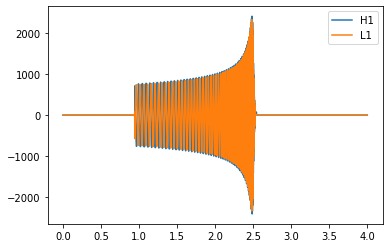

<IPython.core.display.Javascript object>

In [35]:
for i in range(H1_det_wf.data.shape[0]):
    plt.figure()
    plt.plot(H1_det_wf.sample_times[i], H1_det_wf.data[i], label="H1")
    plt.plot(L1_det_wf.sample_times[i], L1_det_wf.data[i], label="L1")
    plt.legend()
#     plt.xlim(2.5, 3.0)

# trying likelihood

In [36]:
from scrinet.analysis import frequencyseries_batch as fs
from scrinet.sample import likelihood

<IPython.core.display.Javascript object>

In [37]:
import bilby

<IPython.core.display.Javascript object>

In [38]:
# initialise a single interferometer representing LIGO Hanford
H1 = bilby.gw.detector.get_empty_interferometer("H1")
# set the strain data at the interferometer
H1.set_strain_data_from_power_spectral_density(
    sampling_frequency=sample_rate, duration=seglen
)

/Users/Rhys/anaconda3/envs/NN_for_PE/lib/python3.8/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise


<IPython.core.display.Javascript object>

In [39]:
delta_f = 1.0 / seglen

<IPython.core.display.Javascript object>

### PSD is problematic atm

In [40]:
# from pycbc
# Dynamic range factor: a large constant for rescaling
# GW strains.  This is 2**69 rounded to 17 sig.fig.

DYN_RANGE_FAC = 5.9029581035870565e20
# DYN_RANGE_FAC = 1.0

<IPython.core.display.Javascript object>

In [41]:
# psd = fs.FrequencySeries(
#     DYN_RANGE_FAC * DYN_RANGE_FAC * H1.power_spectral_density_array.reshape(1, -1),
#     delta_f=delta_f,
#     dtype=tf.float64,
# )

<IPython.core.display.Javascript object>

In [42]:
tf.cast(H1.power_spectral_density_array.reshape(1, -1), tf.float32)

<tf.Tensor: shape=(1, 8193), dtype=float32, numpy=array([[inf, inf, inf, ...,  0.,  0.,  0.]], dtype=float32)>

<IPython.core.display.Javascript object>

In [43]:
# plt.figure()
# plt.loglog(psd.sample_frequencies, psd.data[0])

<IPython.core.display.Javascript object>

In [44]:
signal_plus_noise = H1_det_wf.data[0] + np.random.normal(
    scale=0.000001, size=H1_det_wf.data.shape[1]
)
signal_plus_noise = ts.TimeSeries(
    tf.reshape(signal_plus_noise, (1, -1)), delta_t=delta_t
)

<IPython.core.display.Javascript object>

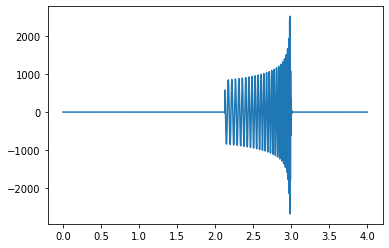

<IPython.core.display.Javascript object>

In [45]:
plt.figure()
plt.plot(signal_plus_noise.sample_times[0], signal_plus_noise.data[0])

In [46]:
template = fs.FrequencySeries(H1_det_wf.to_frequencyseries().data, delta_f=delta_f)
# signal = fs.FrequencySeries(tf.expand_dims(H1_det_wf.to_frequencyseries().data[0],0), delta_f=delta_f)
signal = fs.FrequencySeries(
    tf.expand_dims(signal_plus_noise.to_frequencyseries().data[0], 0), delta_f=delta_f
)

<IPython.core.display.Javascript object>

In [80]:
# @tf.function(experimental_compile=True)
def target_log_prob_fn(x_original):
    x = tf.expand_dims(x_original, 2)
    wvf_params = sample_helpers.WaveformParams(
        m_tot=x[:, 0],
        mass_ratio=x[:, 1],
        chi_1=x[:, 2],
        chi_2=x[:, 3],
        theta=x[:, 4],
        phi=x[:, 5],
        phase_shift=x[:, 6],
        distance=x[:, 7],
    )

    det_params = sample_helpers.DetectorParams(
        ra=x[:, 8], dec=x[:, 9], psi=x[:, 10], time=x[:, 11]
    )

    log_prior = likelihood.simple_gw_prior(wvf_params, det_params)
    cond = tf.reshape(tf.math.is_finite(log_prior), (num_chains, 1))

    # to ensure shapes stay the same make a fiducial waveform
    #  this is fine because the prior is still inf
    temp_m_tot = tf.where(cond, x[:, 0], 60.0)
    temp_q = tf.where(cond, x[:, 1], 1.0)
    temp_chi_1 = tf.where(cond, x[:, 2], 0.0)
    temp_chi_2 = tf.where(cond, x[:, 3], 0.0)

    adjusted_wvf_params = sample_helpers.WaveformParams(
        m_tot=temp_m_tot,
        mass_ratio=temp_q,
        chi_1=temp_chi_1,
        chi_2=temp_chi_2,
        theta=x[:, 4],
        phi=x[:, 5],
        phase_shift=x[:, 6],
        distance=x[:, 7],
    )

    log_like = likelihood.log_likelihood(
        signal,
        adjusted_wvf_params,
        det_params,
        n_batch=num_chains,
        f_lower=f_lower,
        delta_f=delta_f,
        seglen=seglen,
        sample_rate=sample_rate,
        delta_t=delta_t,
        amp_model=amp_model,
        amp_basis=amp_basis,
        phase_model=phase_model,
        phase_basis=phase_basis,
        psd=None,
        detector="H1",
    )
   
    prob = log_like + tf.cast(log_prior, tf.float32)
    prob = tf.cast(prob, tf.float64)
    return prob

<IPython.core.display.Javascript object>

In [81]:
params = [
    wvf_params.m_tot,
    #     tf.constant([[70], [60], [60]]),
    wvf_params.mass_ratio,
    wvf_params.chi_1,
    wvf_params.chi_2,
    wvf_params.theta,
    wvf_params.phi,
    wvf_params.phase_shift,
    wvf_params.distance,
    det_params.ra,
    det_params.dec,
    det_params.psi,
    det_params.time,
]

<IPython.core.display.Javascript object>

In [82]:
params = [tf.cast(param, tf.float64) for param in params]
params = tf.transpose(
    tf.reshape(
        params,
        (12, 3),
    )
)

<IPython.core.display.Javascript object>

In [50]:
from scrinet.analysis import matchedfilter_batch as matchedfilter

<IPython.core.display.Javascript object>

In [51]:
# def inner_product(a, b, delta_f):
#     corr = tf.math.real(tf.math.conj(a) * b)
#     return -0.5 * 4 * delta_f * tf.math.reduce_sum(corr, axis=1)

<IPython.core.display.Javascript object>

In [52]:
p0 = params[0]
num_chains = 3


p0 = p0 + abs(
    np.random.normal(
        0, 0.1 + abs(params[0]) * 0.00001, size=(num_chains, len(params[0]))
    )
)

<IPython.core.display.Javascript object>

In [53]:
qs = np.linspace(2.5, 5.0, 51)
Ts = np.linspace(2.8, 3.2, 51)

<IPython.core.display.Javascript object>

In [54]:
Ms = np.linspace(60, 80, 201)
phis = np.linspace(0, 2 * np.pi, 81)

<IPython.core.display.Javascript object>

tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)
tf.Tensor(34337, shape=(), dtype=int32)


Text(0, 0.5, 'log L(t)')

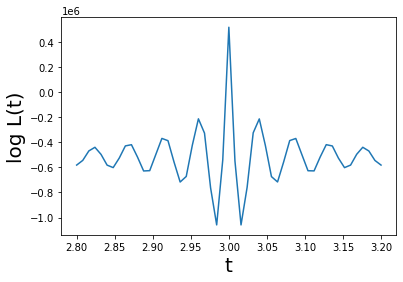

<IPython.core.display.Javascript object>

In [57]:
probs = []
for t in Ts:
    p = params.numpy()
    #     print(t)
    p[0, -1] = t
    p = tf.convert_to_tensor(p)
    #     print(p)
    p = tf.cast(p, tf.float64)
    t_start = time_1.time()
    #     print(target_log_prob_fn(p))
    probs.append(target_log_prob_fn(p)[0])
#     print(f" t = {m}: evaluation took {time.time() - t_start}")

plt.plot(Ts, probs)
plt.xlabel("t", fontsize=(20))
plt.ylabel("log L(t)", fontsize=(20))

In [83]:
# plt.plot(Ts, probs)
# plt.xlabel("t", fontsize=(20))
# plt.ylabel("log L(t)", fontsize=(20))
# # plt.xlim(2.5, 3.5)

<IPython.core.display.Javascript object>

In [84]:
def make_mcmc_kernel_fn(target_log_prob_fn):
    return tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=target_log_prob_fn,
        new_state_fn=tfp.mcmc.random_walk_normal_fn(
            scale=step_size,
        ),
    )


def make_hmc_kernel_fn(target_log_prob_fn):
    return tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn, step_size=step_size, num_leapfrog_steps=3
    )

<IPython.core.display.Javascript object>

In [85]:
@tf.function(experimental_compile=True)
def do_sampling(
    target_log_prob_fn,
    p0=p0,
    num_results=8 * 10 ** 2,
    num_burnin_steps=8 * 10 ** 2,
    ndim=3,
    step_size=0.01,
    sampler="MCMC",
    bijector=True,
    step_size_adapter="simple",
    num_leapfrog_steps=10,
    max_tree_depth=4,
    parallel_iterations=20,
    target_accept_prob=0.7,
):

    if sampler == "HMC":
        inner_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
            tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=target_log_prob_fn,
                step_size=step_size,
                num_leapfrog_steps=5,
            ),
            target_accept_prob=0.7,
            num_adaptation_steps=int(0.75 * num_burnin_steps),
        )

    elif sampler == "NUTS":
        inner_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
            tfp.mcmc.NoUTurnSampler(
                target_log_prob_fn=target_log_prob_fn,
                step_size=step_size,
                max_tree_depth=max_tree_depth,
            ),
            num_adaptation_steps=int(0.75 * num_burnin_steps),
        )

    elif sampler == "MCMC":
        inner_kernel = tfp.mcmc.RandomWalkMetropolis(
            target_log_prob_fn=target_log_prob_fn,
            new_state_fn=tfp.mcmc.random_walk_normal_fn(
                scale=step_size,
            ),
        )

    elif sampler == "PTMCMC":
        inner_kernel = tfp.mcmc.RandomWalkMetropolis(
            target_log_prob_fn=target_log_prob_fn,
            new_state_fn=tfp.mcmc.random_walk_normal_fn(
                scale=step_size,
            ),
        )
        dtype = tf.float64
        inverse_temperatures = 0.5 ** tf.range(4, dtype=dtype)

        inner_kernel = tfp.mcmc.ReplicaExchangeMC(
            target_log_prob_fn=target_log_prob_fn,
            inverse_temperatures=inverse_temperatures,
            make_kernel_fn=make_mcmc_kernel_fn,
        )

    elif sampler == "PTHMC":
        inner_kernel = tfp.mcmc.RandomWalkMetropolis(
            target_log_prob_fn=target_log_prob_fn,
            new_state_fn=tfp.mcmc.random_walk_normal_fn(
                scale=step_size,
            ),
        )
        dtype = tf.float64
        inverse_temperatures = 0.5 ** tf.range(4, dtype=dtype)

        inner_kernel = tfp.mcmc.ReplicaExchangeMC(
            target_log_prob_fn=target_log_prob_fn,
            inverse_temperatures=inverse_temperatures,
            make_kernel_fn=make_hmc_kernel_fn,
        )

    else:
        raise ValueError("kernel not implemented")

    if bijector:
        raise ValueError("bijector not yet implemented")
        kernel = tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=inner_kernel, bijector=distribution.bijector
        )

    else:
        print("not using learnt bijector")
        kernel = tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=inner_kernel, bijector=tfb.Identity()
        )

    posterior = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=p0,
        return_final_kernel_results=True,
        kernel=kernel,
    )

    return posterior

<IPython.core.display.Javascript object>

In [110]:
step_size = 1 * 10 ** -3 * abs(p0[0]) + 0.0005
# step_size = posterior.trace.inner_results.new_step_size[-1]

<IPython.core.display.Javascript object>

In [111]:
step_size = tf.constant(
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01],
    dtype=step_size.dtype,
)

<IPython.core.display.Javascript object>

In [112]:
p0 = params[0] + abs(np.random.normal(0, 0.01, size=(num_chains, len(params[0]))))

<IPython.core.display.Javascript object>

In [113]:
p0 = tf.convert_to_tensor(p0)
p0 = tf.cast(p0, tf.float64)

<IPython.core.display.Javascript object>

In [114]:
param_names = [
    "m_tot",
    "mass_ratio",
    "chi_1",
    "chi_2",
    "theta",
    "phi",
    "phase_shift",
    "distance",
    "ra",
    "dec",
    "psi",
    "time",
]

<IPython.core.display.Javascript object>

In [117]:
num_results = int(5 * 10 ** 3)
num_burnin_steps = int(1 * 10 ** 2)

<IPython.core.display.Javascript object>

In [119]:
%%time
posterior = do_sampling(target_log_prob_fn,
                        sampler = 'MCMC',
                        num_results =num_results,
                        num_burnin_steps = num_burnin_steps,
                        p0=p0,
                        step_size = step_size,
                        bijector=False)


mcmc_trace = posterior.trace

try : 
    p_accept = tf.reduce_mean(
    tf.exp(tf.minimum(mcmc_trace.inner_results.inner_results.log_accept_ratio, 0.0))
    )

except AttributeError: 
    p_accept = tf.reduce_mean(
        tf.exp(tf.minimum(mcmc_trace.inner_results.log_accept_ratio, 0.0))
    )

print(f"Acceptance rate: {p_accept}")

Acceptance rate: 0.0008055515142055834
CPU times: user 1min 18s, sys: 3.03 s, total: 1min 22s
Wall time: 2min 6s


<IPython.core.display.Javascript object>

In [93]:
# posterior.trace.inner_results.new_step_size[-1]

<IPython.core.display.Javascript object>

In [94]:
# posterior.all_states[:, 0:2]

<IPython.core.display.Javascript object>

In [95]:
# posterior.final_kernel_results.inner_results.is_swap_accepted

<IPython.core.display.Javascript object>

In [120]:
mcmc_chains = posterior.all_states
# mcmc_chains = posterior.all_states[:, 0:2]
mcmc_data = sample_helpers.convert_tfp_chains_to_arviz_object(posterior.all_states,
                                                              param_names)


<IPython.core.display.Javascript object>

In [121]:
# mcmc_chains

<IPython.core.display.Javascript object>

In [122]:
# mcmc_chains[:, :, 0:2]

<IPython.core.display.Javascript object>

In [123]:
az.summary(mcmc_data)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
m_tot        70.005  0.005  70.000   70.011      0.003    0.002       3.0   
mass_ratio    4.002  0.001   4.000    4.004      0.001    0.001       3.0   
chi_1         0.008  0.005   0.001    0.015      0.003    0.002       3.0   
chi_2         0.006  0.004   0.003    0.012      0.002    0.002       3.0   
theta         1.056  0.009   1.049    1.069      0.005    0.004       3.0   
phi           3.150  0.006   3.142    3.154      0.003    0.003       3.0   
phase_shift   1.015  0.004   1.012    1.021      0.002    0.002       3.0   
distance      2.304  0.001   2.303    2.306      0.001    0.001       3.0   
ra            1.008  0.005   1.002    1.014      0.003    0.002       3.0   
dec           1.005  0.006   1.000    1.013      0.003    0.003       3.0   
psi           1.004  0.002   1.002    1.007      0.001    0.001       3.0   
time          3.002  0.001   3.000    3.003      0.001    0.001       3.0   

             ess_sd  ess_bulk  ess_tail         r_hat  
m_tot           3.0       3.0       3.0  9.543316e+15  
mass_ratio      3.0       3.0       3.0  9.543316e+15  
chi_1           3.0       3.0       3.0  9.543316e+15  
chi_2           3.0       3.0       3.0  9.543316e+15  
theta           3.0       3.0       3.0  9.543316e+15  
phi             3.0       3.0       3.0  9.543316e+15  
phase_shift     3.0       3.0       3.0  9.543316e+15  
distance        3.0       3.0       3.0  9.543316e+15  
ra              3.0       3.0       3.0  9.543316e+15  
dec             3.0       3.0       3.0  9.543316e+15  
psi             3.0       3.0       3.0  9.543316e+15  
time            3.0       4.0       5.0  2.760000e+00

<IPython.core.display.Javascript object>

In [100]:
wvf_param_dict = wvf_params._asdict()
det_param_dict = det_params._asdict()

<IPython.core.display.Javascript object>

In [101]:
# az.plot_trace(mcmc_data)

<IPython.core.display.Javascript object>

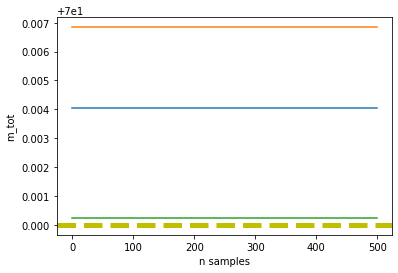

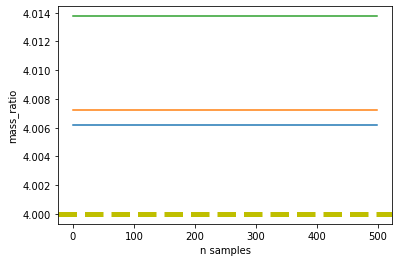

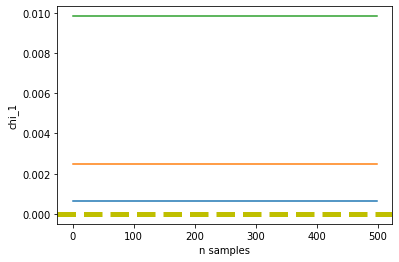

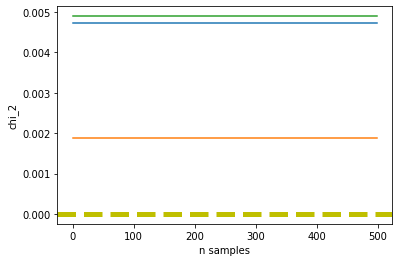

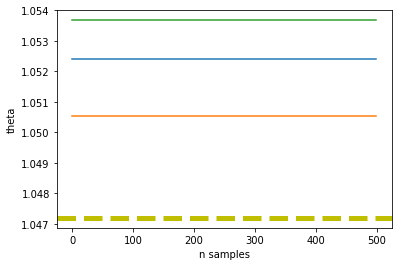

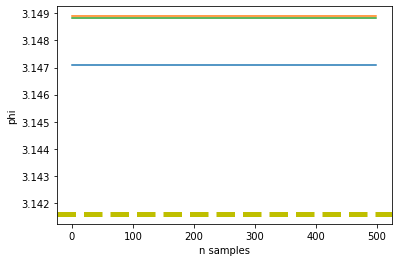

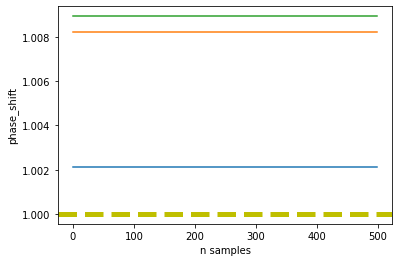

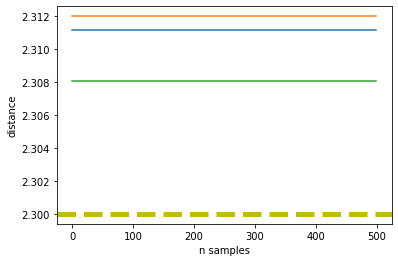

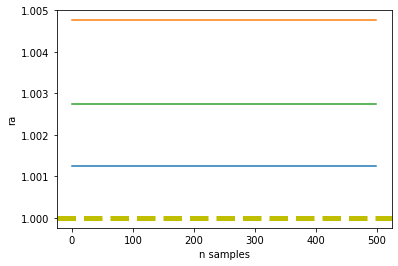

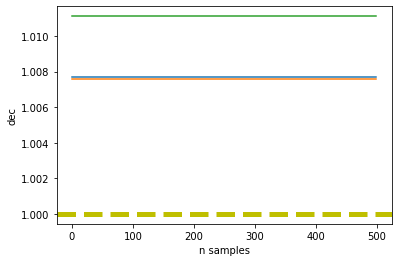

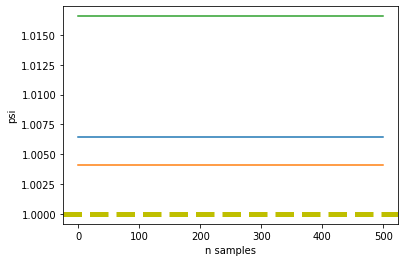

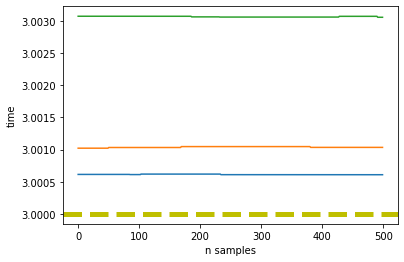

<IPython.core.display.Javascript object>

In [102]:
for i, val in enumerate(params[0].numpy()):
    plt.figure()
    if i <= 7:
        plt.axhline(wvf_param_dict[param_names[i]][0], linestyle="--", lw=5, color="y")
    else:
        plt.axhline(det_param_dict[param_names[i]][0], linestyle="--", lw=5, color="y")
    # normal
    for j in range(num_chains):
        plt.plot(mcmc_chains.numpy().T[i][j])
    # if ptmcmmc
    #     plt.plot(mcmc_chains.numpy().T[i])
    plt.ylabel(param_names[i])
    plt.xlabel("n samples")

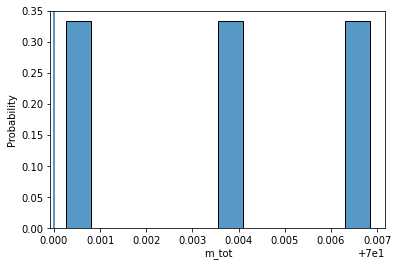

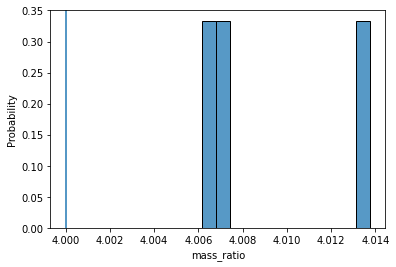

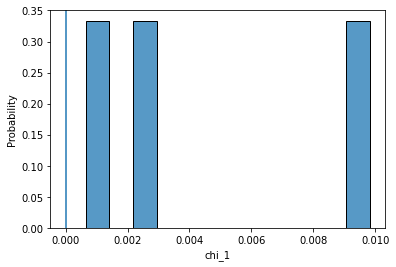

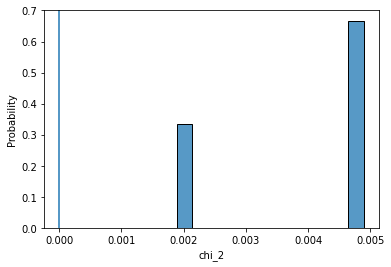

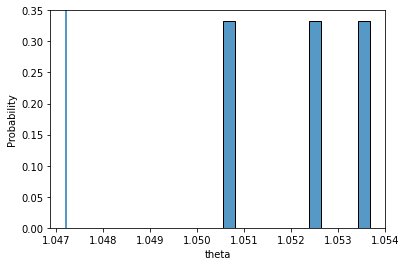

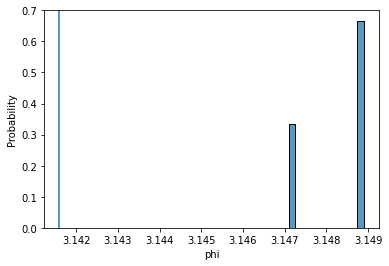

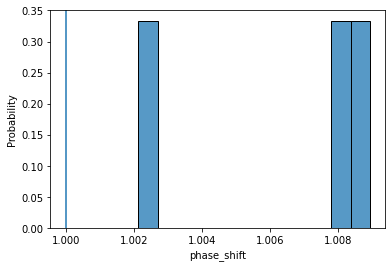

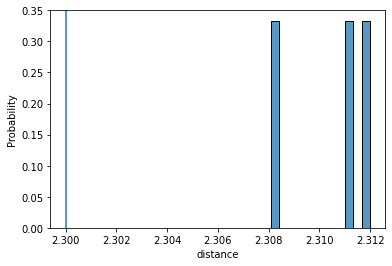

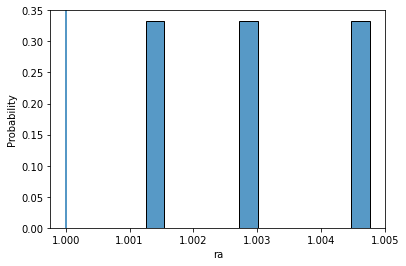

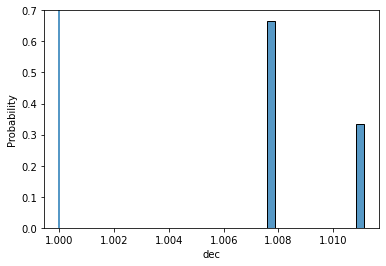

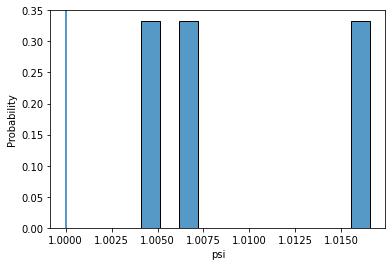

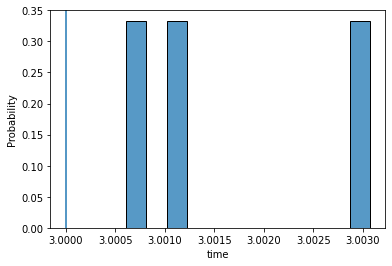

<IPython.core.display.Javascript object>

In [103]:
for i, val in enumerate(params[0].numpy()):
  plt.figure()
  sns.histplot(mcmc_chains.numpy().T[i].flatten(), stat = 'probability')
  plt.xlabel(param_names[i])
  if i <= 7:
    plt.axvline(wvf_param_dict[param_names[i]][0])
  else : 
     plt.axvline(det_param_dict[param_names[i]][0])
  # sns.distplot(non_bij_chains.numpy().T[i].flatten())
#   if i ==0:
#     plt.axvline(val / 8, color = 'y', label = 'true')
#   else : 
#     plt.axvline(val, color = 'y', label = 'true')


In [ ]:
# az.plot_trace(mcmc_data)

In [ ]:
# az.plot_rank(mcmc_data)

In [ ]:
# az.plot_ess(mcmc_data, kind="evolution")

In [ ]:
az.plot_joint(
    mcmc_data,
    var_names=[
        "m_tot",
        "mass_ratio",
    ],
    kind="kde",
)

In [ ]:
az.plot_joint(
    mcmc_data,
    var_names=[
        "time",
        "mass_ratio",
    ],
    kind="kde",
)

In [ ]:
az.plot_joint(
    mcmc_data,
    var_names=[
        "time",
        "phase_shift",
    ],
    kind="kde",
)